In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter

In [3]:
def transform_to_global_frame(landmarks, rotation_matrix, translation_vec):
    # Applying rotation matrix to landmarks
    landmarks = landmarks @ rotation_matrix.T

    # Applying translation
    landmarks += np.array(translation_vec)

    return landmarks

def apply_filter(landmarks, window_length, polyorder):
    """
    Apply Savitzky-Golay filter (window_length must be odd, and polyorder < window_length)
    """

    assert window_length % 2 == 1, "window_length must be odd"
    assert polyorder < window_length, "polyorder must be less than window_length"

    smoothed_translations = savgol_filter(landmarks, window_length, polyorder, axis=0)

    return smoothed_translations

In [4]:
#################### Using the average rotation matrix ####################
rotation_matrix = np.array([[0.07368957,  0.15444128, -0.98525009],
                            [-0.13508931,  0.98037621,  0.14357358],
                            [0.98808943,  0.12251688,  0.09310687]])

#################### Using the average translation vector ####################
translation_vec = np.array([1320.62178736, -181.79693471, 1142.09545961])

# Converting to meters
translation_vec *= 1e-3
landmarks_path = './UDIVAv0.5/MediaPipe/lego_train'
fps = 25
APPLY_FILTER = True

In [5]:
left_shoulder = 23
right_shoulder = 24

left_wrist = 19
right_wrist = 20

############ Entry: 102176 ############
FC1_right_FC2_left_cov:
[[1.         0.09818269]
 [0.09818269 1.        ]]
FC1_right_FC2_right_cov:
[[1.         0.00287712]
 [0.00287712 1.        ]]
FC1_left_FC2_left_cov:
[[1.        0.1250183]
 [0.1250183 1.       ]]
FC1_left_FC2_right_cov:
[[1.         0.03447907]
 [0.03447907 1.        ]]
############ Entry: 051100 ############
FC1_right_FC2_left_cov:
[[ 1.         -0.11542966]
 [-0.11542966  1.        ]]
FC1_right_FC2_right_cov:
[[1.         0.09878742]
 [0.09878742 1.        ]]
FC1_left_FC2_left_cov:
[[ 1.         -0.15121832]
 [-0.15121832  1.        ]]
FC1_left_FC2_right_cov:
[[1.         0.20786935]
 [0.20786935 1.        ]]
############ Entry: 144176 ############
FC1_right_FC2_left_cov:
[[ 1.         -0.33421748]
 [-0.33421748  1.        ]]
FC1_right_FC2_right_cov:
[[ 1.         -0.20549762]
 [-0.20549762  1.        ]]
FC1_left_FC2_left_cov:
[[ 1.         -0.11138897]
 [-0.11138897  1.        ]]
FC1_left_FC2_right_cov:
[[ 1.         -

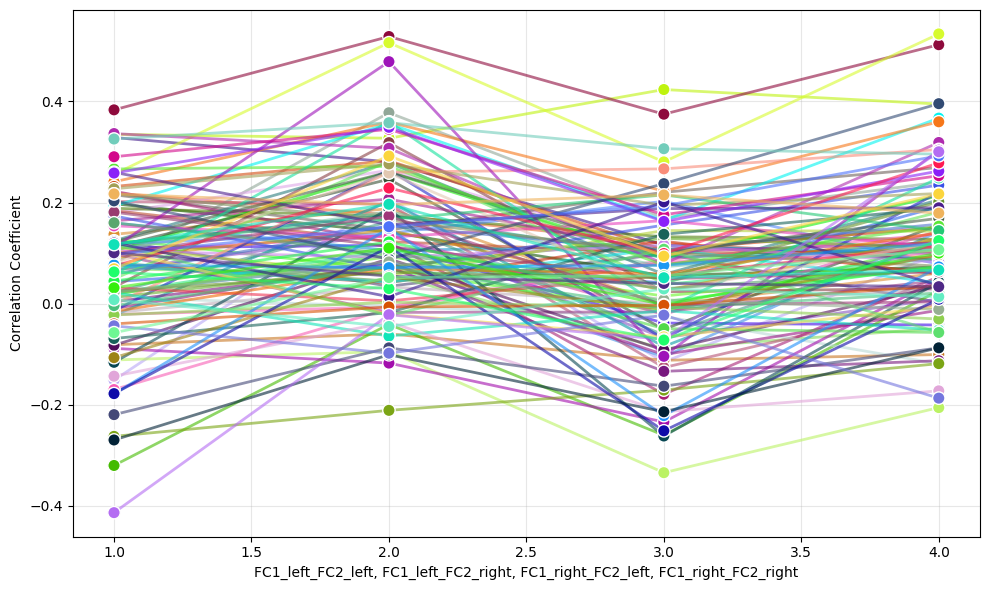

In [5]:
x_values = []
y_values = []
colors = []

# Iterate through all entries in the dataset directory
for entry in os.listdir(landmarks_path):    
    # Construct the full path to the entry
    entry_path = os.path.join(landmarks_path, entry)
    # Check if the entry is a directory
    if os.path.isdir(entry_path):
        landmarks_FC1_path = os.path.join(entry_path, "FC1_landmark_3d_cam.npy")
        landmarks_FC2_path = os.path.join(entry_path, "FC2_landmark_3d_cam.npy")

        landmarks_FC1 = np.load(landmarks_FC1_path)
        landmarks_FC2 = np.load(landmarks_FC2_path)
        
        # Transforming FC1 landmarks to FC2 frame
        landmarks_FC1 = transform_to_global_frame(landmarks_FC1, rotation_matrix, translation_vec)
        
        if APPLY_FILTER:
            landmarks_FC1 = apply_filter(landmarks_FC1, 11, 2)
            landmarks_FC2 = apply_filter(landmarks_FC2, 11, 2)

        FC1_body = (landmarks_FC1[:, 23] + landmarks_FC1[:, 24]) / 2
        FC2_body = (landmarks_FC2[:, 23] + landmarks_FC2[:, 24]) / 2
        
        FC1_left_hand_distance = np.linalg.norm(landmarks_FC1[:, left_wrist] - FC1_body, axis=1)
        FC1_right_hand_distance = np.linalg.norm(landmarks_FC1[:, right_wrist] - FC1_body, axis=1)

        FC2_left_hand_distance = np.linalg.norm(landmarks_FC2[:, left_wrist] - FC2_body, axis=1)
        FC2_right_hand_distance = np.linalg.norm(landmarks_FC2[:, right_wrist] - FC2_body, axis=1)
        
        FC1_left_FC2_left = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
        FC1_left_FC2_right = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)

        FC1_right_FC2_left = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
        FC1_right_FC2_right = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)

        FC1_left_FC2_left_cov = np.corrcoef(FC1_left_FC2_left, rowvar=False)
        FC1_left_FC2_right_cov = np.corrcoef(FC1_left_FC2_right, rowvar=False)

        FC1_right_FC2_left_cov = np.corrcoef(FC1_right_FC2_left, rowvar=False)
        FC1_right_FC2_right_cov = np.corrcoef(FC1_right_FC2_right, rowvar=False)

        # FC1_left_hand_distance = np.linalg.norm(landmarks_FC1[:, left_wrist] - FC2_body, axis=1)
        # FC1_right_hand_distance = np.linalg.norm(landmarks_FC1[:, right_wrist] - FC2_body, axis=1)
        # FC2_left_hand_distance = np.linalg.norm(landmarks_FC2[:, left_wrist] - FC1_body, axis=1)
        # FC2_right_hand_distance = np.linalg.norm(landmarks_FC2[:, right_wrist] - FC1_body, axis=1)
        # FC1_left_FC2_left = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
        # FC1_left_FC2_right = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
        # FC1_right_FC2_left = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
        # FC1_right_FC2_right = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
        # FC1_left_FC2_left_cov = np.corrcoef(FC1_left_FC2_left, rowvar=False)
        # FC1_left_FC2_right_cov = np.corrcoef(FC1_left_FC2_right, rowvar=False)
        # FC1_right_FC2_left_cov = np.corrcoef(FC1_right_FC2_left, rowvar=False)
        # FC1_right_FC2_right_cov = np.corrcoef(FC1_right_FC2_right, rowvar=False)

        x_values.append([1, 2, 3, 4])
        y_values.append([FC1_left_FC2_left_cov[0, 1], FC1_left_FC2_right_cov[0, 1], FC1_right_FC2_left_cov[0, 1], FC1_right_FC2_right_cov[0, 1]])
        color = np.random.rand(3)
        colors.append([color] * 4)

        print(f"############ Entry: {entry} ############")
        print("FC1_right_FC2_left_cov:")
        print(FC1_right_FC2_left_cov)
        print("FC1_right_FC2_right_cov:")
        print(FC1_right_FC2_right_cov)
        print("FC1_left_FC2_left_cov:")
        print(FC1_left_FC2_left_cov)
        print("FC1_left_FC2_right_cov:")
        print(FC1_left_FC2_right_cov)

# plt.figure(figsize=(8, 6))
# plt.scatter(x_values, y_values, c=colors, edgecolor='w', alpha=0.8)
# plt.xlabel('FC1_left_FC2_left, FC1_left_FC2_right, FC1_right_FC2_left, FC1_right_FC2_right')
# plt.ylabel('Correlation Coefficient')

# plt.show()


# Create figure and plot all elements
plt.figure(figsize=(10, 6))

# Plot each batch's points and line
for x, y, color in zip(x_values, y_values, colors):
    # Plot points with edge outline
    plt.scatter(x, y, color=color, s=80, edgecolor='white', linewidth=1, zorder=3)
    
    # Connect points with a line (same color, slightly transparent)
    plt.plot(x, y, color=color[0], linewidth=2, alpha=0.6, zorder=2)


plt.xlabel('FC1_left_FC2_left, FC1_left_FC2_right, FC1_right_FC2_left, FC1_right_FC2_right')
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the final result
plt.show()
        

(1218524, 33, 3)
FC1_right_FC2_left_cov:
[[1.        0.0330694]
 [0.0330694 1.       ]]
FC1_right_FC2_right_cov:
[[1.         0.08122287]
 [0.08122287 1.        ]]
FC1_left_FC2_left_cov:
[[1.         0.05265531]
 [0.05265531 1.        ]]
FC1_left_FC2_right_cov:
[[1.         0.10392048]
 [0.10392048 1.        ]]


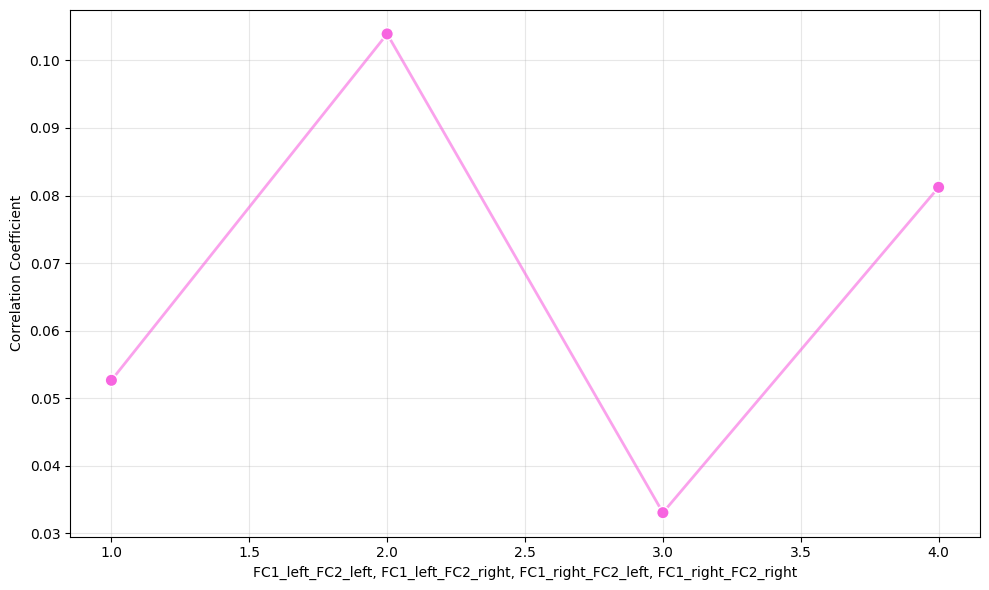

In [6]:
# Concatenate all of them
x_values = []
y_values = []
colors = []

landmarks_FC1_total = np.empty((0, 33, 3))
landmarks_FC2_total = np.empty((0, 33, 3))



# Iterate through all entries in the dataset directory
for entry in os.listdir(landmarks_path):    
    # Construct the full path to the entry
    entry_path = os.path.join(landmarks_path, entry)
    # Check if the entry is a directory
    if os.path.isdir(entry_path):
        landmarks_FC1_path = os.path.join(entry_path, "FC1_landmark_3d_cam.npy")
        landmarks_FC2_path = os.path.join(entry_path, "FC2_landmark_3d_cam.npy")

        landmarks_FC1 = np.load(landmarks_FC1_path)
        landmarks_FC2 = np.load(landmarks_FC2_path)
        
        # Transforming FC1 landmarks to FC2 frame
        landmarks_FC1 = transform_to_global_frame(landmarks_FC1, rotation_matrix, translation_vec)
        
        if APPLY_FILTER:
            landmarks_FC1 = apply_filter(landmarks_FC1, 11, 2)
            landmarks_FC2 = apply_filter(landmarks_FC2, 11, 2)

        landmarks_FC1_total = np.vstack((landmarks_FC1_total, landmarks_FC1))
        landmarks_FC2_total = np.vstack((landmarks_FC2_total, landmarks_FC2))

print(landmarks_FC1_total.shape)

FC1_body = (landmarks_FC1_total[:, 23] + landmarks_FC1_total[:, 24] + landmarks_FC1_total[:, 11] + landmarks_FC1_total[:, 12]) / 4
FC2_body = (landmarks_FC2_total[:, 23] + landmarks_FC2_total[:, 24] + landmarks_FC2_total[:, 11] + landmarks_FC2_total[:, 12]) / 4

FC1_left_hand_distance = np.linalg.norm(landmarks_FC1_total[:, left_wrist] - FC1_body, axis=1)
FC1_right_hand_distance = np.linalg.norm(landmarks_FC1_total[:, right_wrist] - FC1_body, axis=1)
FC2_left_hand_distance = np.linalg.norm(landmarks_FC2_total[:, left_wrist] - FC2_body, axis=1)
FC2_right_hand_distance = np.linalg.norm(landmarks_FC2_total[:, right_wrist] - FC2_body, axis=1)

FC1_left_FC2_left = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
FC1_left_FC2_right = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
FC1_right_FC2_left = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
FC1_right_FC2_right = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
FC1_left_FC2_left_cov = np.corrcoef(FC1_left_FC2_left, rowvar=False)
FC1_left_FC2_right_cov = np.corrcoef(FC1_left_FC2_right, rowvar=False)
FC1_right_FC2_left_cov = np.corrcoef(FC1_right_FC2_left, rowvar=False)
FC1_right_FC2_right_cov = np.corrcoef(FC1_right_FC2_right, rowvar=False)
# FC1_left_hand_distance = np.linalg.norm(landmarks_FC1[:, left_wrist] - FC2_body, axis=1)
# FC1_right_hand_distance = np.linalg.norm(landmarks_FC1[:, right_wrist] - FC2_body, axis=1)
# FC2_left_hand_distance = np.linalg.norm(landmarks_FC2[:, left_wrist] - FC1_body, axis=1)
# FC2_right_hand_distance = np.linalg.norm(landmarks_FC2[:, right_wrist] - FC1_body, axis=1)
# FC1_left_FC2_left = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
# FC1_left_FC2_right = np.concatenate((FC1_left_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
# FC1_right_FC2_left = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_left_hand_distance.reshape(-1, 1)), axis=1)
# FC1_right_FC2_right = np.concatenate((FC1_right_hand_distance.reshape(-1, 1), FC2_right_hand_distance.reshape(-1, 1)), axis=1)
# FC1_left_FC2_left_cov = np.corrcoef(FC1_left_FC2_left, rowvar=False)
# FC1_left_FC2_right_cov = np.corrcoef(FC1_left_FC2_right, rowvar=False)
# FC1_right_FC2_left_cov = np.corrcoef(FC1_right_FC2_left, rowvar=False)
# FC1_right_FC2_right_cov = np.corrcoef(FC1_right_FC2_right, rowvar=False)
x_values.append([1, 2, 3, 4])
y_values.append([FC1_left_FC2_left_cov[0, 1], FC1_left_FC2_right_cov[0, 1], FC1_right_FC2_left_cov[0, 1], FC1_right_FC2_right_cov[0, 1]])
color = np.random.rand(3)
colors.append([color] * 4)
print("FC1_right_FC2_left_cov:")
print(FC1_right_FC2_left_cov)
print("FC1_right_FC2_right_cov:")
print(FC1_right_FC2_right_cov)
print("FC1_left_FC2_left_cov:")
print(FC1_left_FC2_left_cov)
print("FC1_left_FC2_right_cov:")
print(FC1_left_FC2_right_cov)

# Create figure and plot all elements
plt.figure(figsize=(10, 6))

# Plot each batch's points and line
for x, y, color in zip(x_values, y_values, colors):
    # Plot points with edge outline
    plt.scatter(x, y, color=color, s=80, edgecolor='white', linewidth=1, zorder=3)
    
    # Connect points with a line (same color, slightly transparent)
    plt.plot(x, y, color=color[0], linewidth=2, alpha=0.6, zorder=2)


plt.xlabel('FC1_left_FC2_left, FC1_left_FC2_right, FC1_right_FC2_left, FC1_right_FC2_right')
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the final result
plt.show()
        

### Cross-Correlation Between Hand-Torsoe Distances

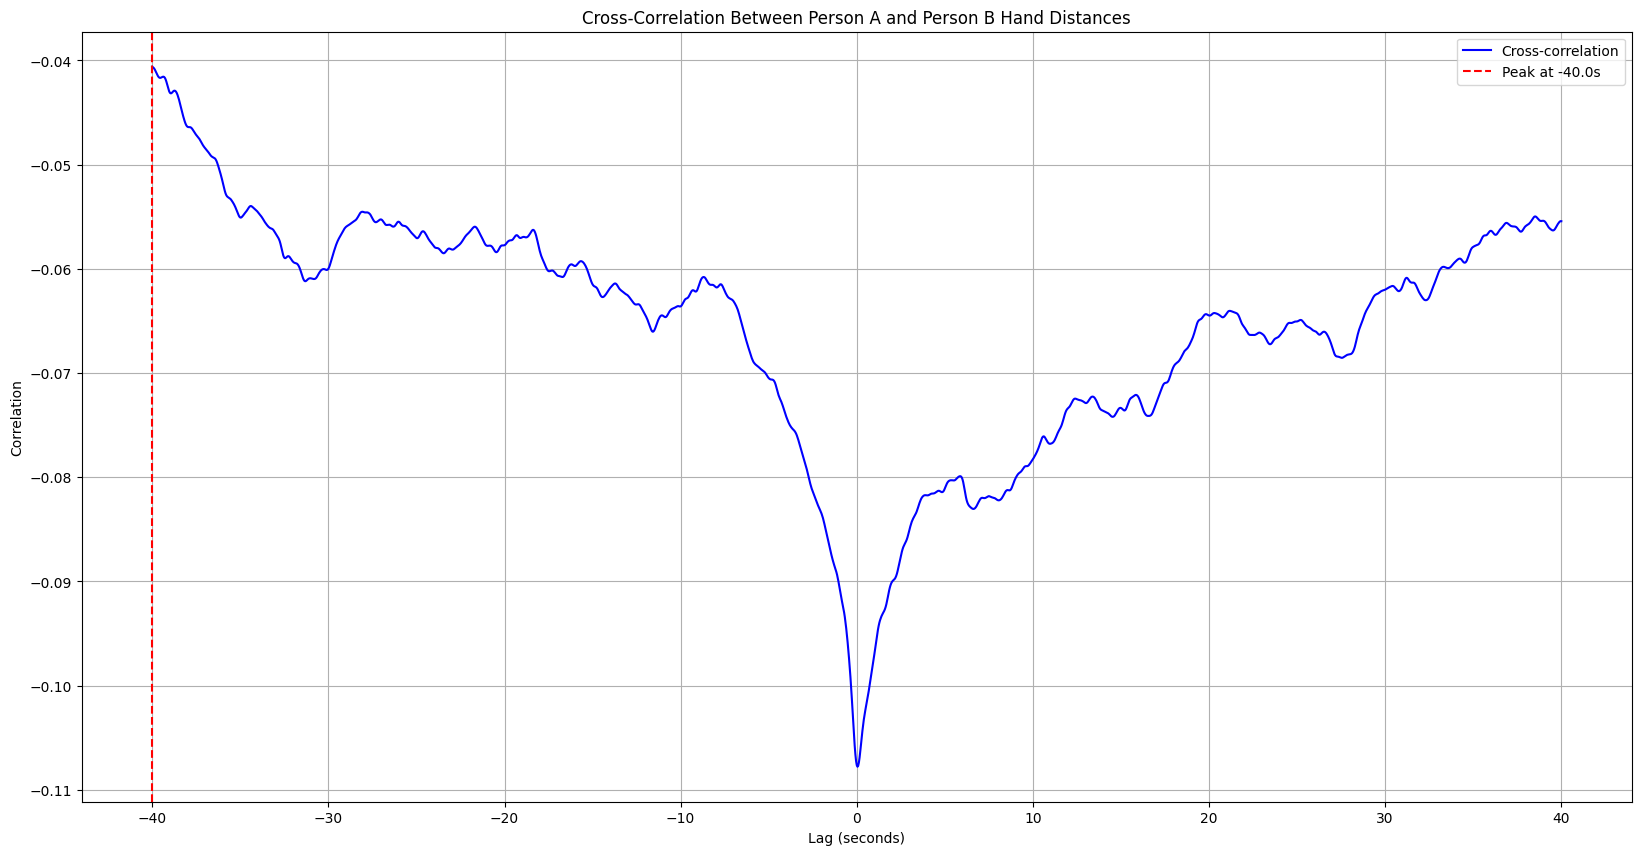

In [13]:
landmarks_FC1_total = np.empty((0, 33, 3))
landmarks_FC2_total = np.empty((0, 33, 3))

# Iterate through all entries in the dataset directory
for entry in os.listdir(landmarks_path):    
    # Construct the full path to the entry
    entry_path = os.path.join(landmarks_path, entry)
    # Check if the entry is a directory
    if os.path.isdir(entry_path):
        landmarks_FC1_path = os.path.join(entry_path, "FC1_landmark_3d_cam.npy")
        landmarks_FC2_path = os.path.join(entry_path, "FC2_landmark_3d_cam.npy")

        landmarks_FC1 = np.load(landmarks_FC1_path)
        landmarks_FC2 = np.load(landmarks_FC2_path)
        
        # Transforming FC1 landmarks to FC2 frame
        landmarks_FC1 = transform_to_global_frame(landmarks_FC1, rotation_matrix, translation_vec)
        
        if APPLY_FILTER:
            landmarks_FC1 = apply_filter(landmarks_FC1, 11, 2)
            landmarks_FC2 = apply_filter(landmarks_FC2, 11, 2)

        landmarks_FC1_total = np.vstack((landmarks_FC1_total, landmarks_FC1))
        landmarks_FC2_total = np.vstack((landmarks_FC2_total, landmarks_FC2))

FC1_body = (landmarks_FC1_total[:, 23] + landmarks_FC1_total[:, 24]) / 2
FC2_body = (landmarks_FC2_total[:, 23] + landmarks_FC2_total[:, 24]) / 2

FC1_left_hand_distance = np.linalg.norm(landmarks_FC1_total[:, left_wrist] - FC1_body, axis=1)
FC1_right_hand_distance = np.linalg.norm(landmarks_FC1_total[:, right_wrist] - FC1_body, axis=1)
FC2_left_hand_distance = np.linalg.norm(landmarks_FC2_total[:, left_wrist] - FC2_body, axis=1)
FC2_right_hand_distance = np.linalg.norm(landmarks_FC2_total[:, right_wrist] - FC2_body, axis=1)

# Normalize the signals
FC1_right_hand_distance_normalized = (FC1_right_hand_distance - np.mean(FC1_right_hand_distance)) / np.std(FC1_right_hand_distance)
FC2_right_hand_distance_normalized = (FC2_right_hand_distance - np.mean(FC2_right_hand_distance)) / np.std(FC2_right_hand_distance)

max_lag = 1000
cross_corr = np.correlate(FC1_right_hand_distance_normalized, -1 * FC2_right_hand_distance_normalized, mode='full')
lags = np.arange(-max_lag, max_lag + 1)

# Truncate to the desired lags
cross_corr = cross_corr[(len(cross_corr) // 2 - max_lag) : (len(cross_corr) // 2 + max_lag + 1)]
cross_corr /= len(FC1_right_hand_distance)  # Normalize by the number of points

# Find the lag with maximum correlation
optimal_lag = lags[np.argmax(cross_corr)]
optimal_lag_time = optimal_lag * 0.04  # Convert lag index to seconds (0.04s per step)

# Plot
plt.figure(figsize=(20, 10))
plt.plot(lags * 0.04, cross_corr, 'b', label='Cross-correlation')
plt.axvline(optimal_lag_time, color='r', linestyle='--', label=f'Peak at {optimal_lag_time:.1f}s')
plt.xlabel('Lag (seconds)')
plt.ylabel('Correlation')
plt.title('Cross-Correlation Between Person A and Person B Hand Distances')
plt.legend()
plt.grid()

plt.show()

### Hand Position Heatmap

In [6]:
landmarks_FC1_total = np.empty((0, 33, 3))
landmarks_FC2_total = np.empty((0, 33, 3))

# Iterate through all entries in the dataset directory
for entry in os.listdir(landmarks_path):    
    # Construct the full path to the entry
    entry_path = os.path.join(landmarks_path, entry)
    # Check if the entry is a directory
    if os.path.isdir(entry_path):
        landmarks_FC1_path = os.path.join(entry_path, "FC1_landmark_3d_cam.npy")
        landmarks_FC2_path = os.path.join(entry_path, "FC2_landmark_3d_cam.npy")

        landmarks_FC1 = np.load(landmarks_FC1_path)
        landmarks_FC2 = np.load(landmarks_FC2_path)
        
        # Transforming FC1 landmarks to FC2 frame
        landmarks_FC1 = transform_to_global_frame(landmarks_FC1, rotation_matrix, translation_vec)
        
        if APPLY_FILTER:
            landmarks_FC1 = apply_filter(landmarks_FC1, 11, 2)
            landmarks_FC2 = apply_filter(landmarks_FC2, 11, 2)

        landmarks_FC1_total = np.vstack((landmarks_FC1_total, landmarks_FC1))
        landmarks_FC2_total = np.vstack((landmarks_FC2_total, landmarks_FC2))

FC1_left_hand = landmarks_FC1_total[:, 15, :].reshape(-1, 3)
FC1_right_hand = landmarks_FC1_total[:, 16, :].reshape(-1, 3)

FC2_left_hand = landmarks_FC2_total[:, 15, :].reshape(-1, 3)
FC2_right_hand = landmarks_FC2_total[:, 16, :].reshape(-1, 3)


FC1_left_hand_x = FC1_left_hand[:, 0]
FC1_left_hand_y = FC1_left_hand[:, 1]
FC1_left_hand_z = FC1_left_hand[:, 2]

FC1_right_hand_x = FC1_right_hand[:, 0]
FC1_right_hand_y = FC1_right_hand[:, 1]
FC1_right_hand_z = FC1_right_hand[:, 2]

FC2_left_hand_x = FC2_left_hand[:, 0]
FC2_left_hand_y = FC2_left_hand[:, 1]
FC2_left_hand_z = FC2_left_hand[:, 2]

FC2_right_hand_x = FC2_right_hand[:, 0]
FC2_right_hand_y = FC2_right_hand[:, 1]
FC2_right_hand_z = FC2_right_hand[:, 2]

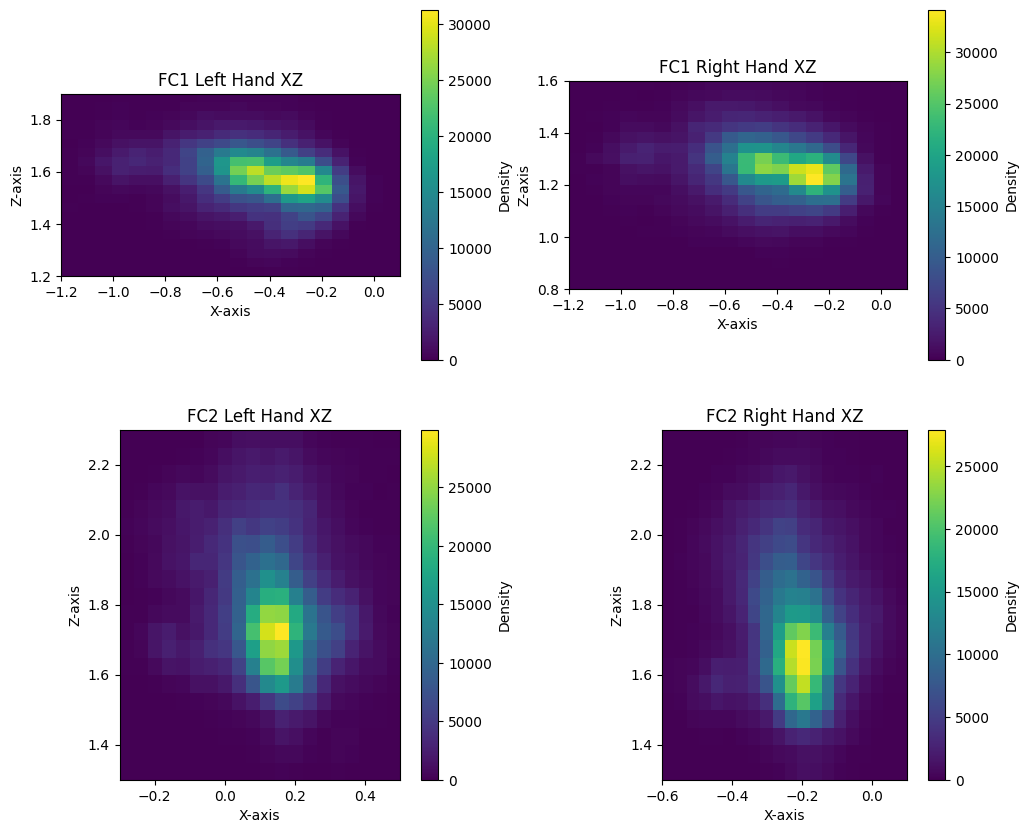

In [86]:
# Define the number of bins for the histogram
bins = 20

# Create a figure
plt.figure(figsize=(12, 10))

# --- Heatmap 1: XY Projection ---
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, position 1

# Compute the 2D histogram
heatmap1l, xedges1l, yedges1l = np.histogram2d(FC1_left_hand_x, FC1_left_hand_z, bins=bins, range = np.array([[-1.2, 0.1], [1.2, 1.9]]))

plt.imshow(heatmap1l.T, 
           extent=[xedges1l[0], xedges1l[-1], yedges1l[0], yedges1l[-1]], 
           origin='lower', 
           cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title('FC1 Left Hand XZ')

# --- Heatmap 2: XY Projection ---
plt.subplot(2, 2, 2)

# Compute the 2D histogram
heatmap1r, xedges1r, yedges1r = np.histogram2d(FC1_right_hand_x, FC1_right_hand_z, bins=bins, range = np.array([[-1.2, 0.1], [0.8, 1.6]]))

plt.imshow(heatmap1r.T, 
           extent=[xedges1r[0], xedges1r[-1], yedges1r[0], yedges1r[-1]], 
           origin='lower', 
           cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title('FC1 Right Hand XZ')

# --- Heatmap 3: XY Projection ---
plt.subplot(2, 2, 3) 

# Compute the 2D histogram
heatmap2l, xedges2l, yedges2l = np.histogram2d(FC2_left_hand_x, FC2_left_hand_z, bins=bins, range = np.array([[-0.3, 0.5], [1.3, 2.3]]))

plt.imshow(heatmap2l.T, 
           extent=[xedges2l[0], xedges2l[-1], yedges2l[0], yedges2l[-1]], 
           origin='lower', 
           cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title('FC2 Left Hand XZ')

# --- Heatmap 4: XY Projection ---
plt.subplot(2, 2, 4) 

# Compute the 2D histogram
heatmap2r, xedges2r, yedges2r = np.histogram2d(FC2_right_hand_x, FC2_right_hand_z, bins=bins, range = np.array([[-0.6, 0.1], [1.3, 2.3]]))

plt.imshow(heatmap2r.T, 
           extent=[xedges2r[0], xedges2r[-1], yedges2r[0], yedges2r[-1]], 
           origin='lower', 
           cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title('FC2 Right Hand XZ')


plt.show()

In [ ]:
# Working region
# FC1: [-0.55, -, 1.12] - [-0.16, -, 1.655]

# FC2: [-0.285, -, 1.50] - [0.22, -, 1,90]

In [170]:
yedges1l

array([1.2  , 1.235, 1.27 , 1.305, 1.34 , 1.375, 1.41 , 1.445, 1.48 ,
       1.515, 1.55 , 1.585, 1.62 , 1.655, 1.69 , 1.725, 1.76 , 1.795,
       1.83 , 1.865, 1.9  ])

In [174]:
heatmap1l[:, 13]

array([1.7200e+02, 4.7100e+02, 1.2100e+03, 2.2880e+03, 3.1220e+03,
       2.4590e+03, 3.5780e+03, 6.3950e+03, 9.7270e+03, 1.2897e+04,
       1.4882e+04, 1.3950e+04, 1.1607e+04, 8.7740e+03, 5.9580e+03,
       3.9950e+03, 1.5100e+03, 1.4200e+02, 1.2000e+01, 2.0000e+00])

In [73]:
np.mean((landmarks_FC2_total[:, 23, :] + landmarks_FC2_total[:, 24, :]) / 2, axis=0)

array([-0.06983178,  0.44413028,  2.08043716])

In [72]:
np.min(landmarks_FC2_total[:, 24, 2])

1.240974414415349

In [74]:
np.std((landmarks_FC2_total[:, 23, :] + landmarks_FC2_total[:, 24, :]) / 2, axis=0)

array([0.11671106, 0.04160648, 0.20946   ])

### Tokens

In [152]:
tokens = dict()

In [154]:
class TOKENS:
    IN_WORKING_REGION = 0
    OUT_WORKING_REGION = 1

In [177]:
tokens['FC1_left_region'] = np.empty(landmarks_FC1_total.shape[0])
tokens['FC1_right_region'] = np.empty(landmarks_FC1_total.shape[0])
tokens['FC2_left_region'] = np.empty(landmarks_FC2_total.shape[0])
tokens['FC2_right_region'] = np.empty(landmarks_FC2_total.shape[0])

for i in range(landmarks_FC1_total.shape[0]):
    if landmarks_FC1_total[i, 15, 0] < -0.16 and landmarks_FC1_total[i, 15, 0] > -0.55 \
    and landmarks_FC1_total[i, 15, 2] < 1.655 and landmarks_FC1_total[i, 15, 2] > 1.12:
        tokens['FC1_left_region'][i] = TOKENS.IN_WORKING_REGION
    else:
        tokens['FC1_left_region'][i] = TOKENS.OUT_WORKING_REGION

    if landmarks_FC1_total[i, 16, 0] < -0.16 and landmarks_FC1_total[i, 16, 0] > -0.55 \
    and landmarks_FC1_total[i, 16, 2] < 1.655 and landmarks_FC1_total[i, 16, 2] > 1.12:
        tokens['FC1_right_region'][i] = TOKENS.IN_WORKING_REGION
    else:
        tokens['FC1_right_region'][i] = TOKENS.OUT_WORKING_REGION

    if landmarks_FC2_total[i, 15, 0] < 0.22 and landmarks_FC2_total[i, 15, 0] > -0.285 \
    and landmarks_FC2_total[i, 15, 2] < 1.90 and landmarks_FC2_total[i, 15, 2] > 1.50:
        tokens['FC2_left_region'][i] = TOKENS.IN_WORKING_REGION
    else:
        tokens['FC2_left_region'][i] = TOKENS.OUT_WORKING_REGION

    if landmarks_FC2_total[i, 16, 0] < 0.22 and landmarks_FC2_total[i, 16, 0] > -0.285 \
    and landmarks_FC2_total[i, 16, 2] < 1.90 and landmarks_FC2_total[i, 16, 2] > 1.50:
        tokens['FC2_right_region'][i] = TOKENS.IN_WORKING_REGION
    else:
        tokens['FC2_right_region'][i] = TOKENS.OUT_WORKING_REGION

In [178]:
np.count_nonzero(tokens['FC1_left_region']) / landmarks_FC2_total.shape[0]

0.40461821022811206